# Lab 11: Sequence-to-sequence Character-Level Machine Translation

This notebook was modified from an example developed in 2017 and updated in 2020 by Francis Chollet, a Google AI engineer and author. The notebook uses a paired database of short English and French phrases to create character-level translations. Although this is a workable approach, note that most machine translation solutions (whether deep learning or not) work at the word level.

*Important:*
Make sure to turn on GPU acceleration for your notebook runtime: This speeds up the training by a factor of ten.


## Introduction

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.


## Setup


In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.12.0'

## Download the data


In [2]:
# We have previously used wget for this task, but curl is quite similar.
# curl supports more protocols, but here we are simply using it to get
# a file from the web with https.
!curl -O https://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip
# If you run this more than once, you will be asked if you want to replace
# the first copy of the file(s).

data_path = "fra.txt" # Path to the data txt file on disk.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7246k  100 7246k    0     0  4467k      0  0:00:01  0:00:01 --:--:-- 4464k
Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


## Configuration


In [3]:
batch_size = 64  # Batch size for training.
epochs = 15  # Number of epochs to train for. We'll raise this later.
latent_dim = 256  # Latent dimensionality of the thought vector encoding space.

# The French-English file contains about 56,000 phrase pairs
# We probably cannot fit all of the input data into memory.
num_samples = 28000  # How big a subset of the dataset to use

## Prepare the data


In [4]:
# Read the data from the file, line by line
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# The *with* statement is a handy way of managing file I/O. It ensures that
# the file gets closed once we are done with it.
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

len(input_texts), len(target_texts) # These should match:
# The length of each should match the num_samples configuration option above.

(28000, 28000)

In [5]:
# Randomize the order of the texts
arr = np.arange(num_samples)
np.random.shuffle(arr)

input_texts = [input_texts[i] for i in arr]
target_texts = [target_texts[i] for i in arr]

In [6]:
print(type(f)) # f is still a valid object

try:
  f.tell() # For an open file, this would give the read position
except ValueError: # But the file is closed, thanks to the with: statement
    print("File is closed.")

<class '_io.TextIOWrapper'>
File is closed.


In [7]:
# Take a peek at the first few pairs of input and target texts
[ (i, t) for i, t in enumerate(zip(input_texts[:15], target_texts[:15]))]

[(0, ('Cows give milk.', '\tLes vaches donnent du lait.\n')),
 (1, ('I felt naked.', '\tJe me suis senti nue.\n')),
 (2, ("I'll tell you.", '\tJe te dirai.\n')),
 (3, ('I love bananas.', "\tJ'adore les bananes.\n")),
 (4, ('I had a seizure.', "\tJ'ai eu une attaque cardiaque.\n")),
 (5, ("You're funny.", "\tT'es marrante.\n")),
 (6, ('Dreams come true.', '\tLes rêves deviennent réalité.\n')),
 (7, ('Tom cried again.', '\tTom a de nouveau pleuré.\n')),
 (8, ('I was speechless.', '\tJ’étais sans voix.\n')),
 (9, ('Now help me.', '\tAide-moi là.\n')),
 (10, ('He is foolish.', '\tIl est idiot.\n')),
 (11, ('You smashed it.', "\tTu l'as détruit.\n")),
 (12, ("It'll be tricky.", '\tÇa sera délicat.\n')),
 (13, ("You're clever.", '\tVous êtes malin.\n')),
 (14, ('Tom loved us.', '\tTom nous aimait.\n'))]

Note how the parsing of the target data from the text file has naturally led to the creation of a start of sequence token (i.e., \t) and an end of sequence token (i.e., \n). As long as they each have a unique encoding value, these tokens could be anything you want. Later on in this notebook, we will define a utility function called decode_sequence(). This function will issue a \t to prompt the decoder to start emitting characters. The function also has a test to see when a sequence has ended, and that test looks for a \n as a signal from the decoder that a target sequence is done.

In [11]:
#
# Exercise 11.1: Display the list of input characters
#
input_characters
#We can see input characters starting from symbols, numbers, upper characters, lower characters

{' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'é'}

In [12]:
#
# Exercise 11.2: Display the list of target characters
#
target_characters

#The target charcacters are similar with addition of \t and \n
#Then followed by symbols, numbers, characters

{'\t',
 '\n',
 ' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '«',
 '»',
 'À',
 'Ç',
 'É',
 'Ê',
 'Ô',
 'à',
 'â',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'ï',
 'ô',
 'ù',
 'û',
 'œ',
 '\u2009',
 '‘',
 '’',
 '\u202f'}

In [13]:
# Because this is a character-level model, the vocab for both the encoder
# side and the decoder side is the list of unique characters in each set.
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

# These need not match
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)

Number of unique input tokens: 76
Number of unique output tokens: 102


Linguistic curiosity question: Why would the character list be larger for French than for English?

In [14]:
# These are the "message lengths" calibrated in the number of characters.
# Because we are doing a character-level model these values define how far
# the encoder LSTM and the decoder LSTM (respectively) need to be "unrolled"
# in order to do the training. 
#
# Also remember that shorter sequences will need to be padded.
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Max sequence length for inputs: 18
Max sequence length for outputs: 59


In [15]:
# Next we will vectorize all of the input and target messages using one hot encoding

# First, make Python dictionaries for the input and target messages
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

# Remember that the seq2seq data is actually a 3-tuple. The encoder takes 
# input messages as input but creates no output except for the hidden state.
# The decoder has both inputs and targets. These three lines fill vectors
# with zeroes to initialize them.

# The encoder inputs - will hold character sequences for short English phrases
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")

# The decoder inputs - will hold character sequences for short French phrases
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

# Same size numpy array for the decoder targets
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")



In [16]:
#
# Exercise 11.3: Display the contents of input_token_index
#
input_token_index
#We can see the input list with index

{' ': 0,
 '!': 1,
 '"': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '/': 10,
 '0': 11,
 '1': 12,
 '2': 13,
 '3': 14,
 '4': 15,
 '5': 16,
 '6': 17,
 '7': 18,
 '8': 19,
 '9': 20,
 ':': 21,
 '?': 22,
 'A': 23,
 'B': 24,
 'C': 25,
 'D': 26,
 'E': 27,
 'F': 28,
 'G': 29,
 'H': 30,
 'I': 31,
 'J': 32,
 'K': 33,
 'L': 34,
 'M': 35,
 'N': 36,
 'O': 37,
 'P': 38,
 'Q': 39,
 'R': 40,
 'S': 41,
 'T': 42,
 'U': 43,
 'V': 44,
 'W': 45,
 'X': 46,
 'Y': 47,
 'Z': 48,
 'a': 49,
 'b': 50,
 'c': 51,
 'd': 52,
 'e': 53,
 'f': 54,
 'g': 55,
 'h': 56,
 'i': 57,
 'j': 58,
 'k': 59,
 'l': 60,
 'm': 61,
 'n': 62,
 'o': 63,
 'p': 64,
 'q': 65,
 'r': 66,
 's': 67,
 't': 68,
 'u': 69,
 'v': 70,
 'w': 71,
 'x': 72,
 'y': 73,
 'z': 74,
 'é': 75}

In [18]:
#
# Exercise 11.4: Compare the contents of input_token_index and target_token_index
# Write a comment noting what you find.
#
[ (i, t) for i, t in enumerate(zip(input_token_index, target_token_index))]
#Comparing the input and target we see \t and \n additional in target tokens
#\t represents the start and \n represent the end
#We see how the encoder compresses to lower, and the same signals are passed to decoder
#with start and end additionally to predict

[(0, (' ', '\t')),
 (1, ('!', '\n')),
 (2, ('"', ' ')),
 (3, ('$', '!')),
 (4, ('%', '"')),
 (5, ('&', '$')),
 (6, ("'", '%')),
 (7, (',', '&')),
 (8, ('-', "'")),
 (9, ('.', '(')),
 (10, ('/', ')')),
 (11, ('0', ',')),
 (12, ('1', '-')),
 (13, ('2', '.')),
 (14, ('3', '0')),
 (15, ('4', '1')),
 (16, ('5', '2')),
 (17, ('6', '3')),
 (18, ('7', '4')),
 (19, ('8', '5')),
 (20, ('9', '6')),
 (21, (':', '7')),
 (22, ('?', '8')),
 (23, ('A', '9')),
 (24, ('B', ':')),
 (25, ('C', '?')),
 (26, ('D', 'A')),
 (27, ('E', 'B')),
 (28, ('F', 'C')),
 (29, ('G', 'D')),
 (30, ('H', 'E')),
 (31, ('I', 'F')),
 (32, ('J', 'G')),
 (33, ('K', 'H')),
 (34, ('L', 'I')),
 (35, ('M', 'J')),
 (36, ('N', 'K')),
 (37, ('O', 'L')),
 (38, ('P', 'M')),
 (39, ('Q', 'N')),
 (40, ('R', 'O')),
 (41, ('S', 'P')),
 (42, ('T', 'Q')),
 (43, ('U', 'R')),
 (44, ('V', 'S')),
 (45, ('W', 'T')),
 (46, ('X', 'U')),
 (47, ('Y', 'V')),
 (48, ('Z', 'W')),
 (49, ('a', 'X')),
 (50, ('b', 'Y')),
 (51, ('c', 'a')),
 (52, ('d', 'b')),
 

In [19]:
# Now fill the vectors with one hot encoded sequences

# Iterate over all of our phrase pairs
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    # Iterate over all of the characters in the input phrase
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0

    # This adds padding with spaces
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    # Iterate over all of the characters in the target phrase. Here we are
    # filling two vectors 
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    
    # This adds padding with spaces
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [20]:
len(encoder_input_data), len(decoder_input_data), len(decoder_target_data)

(28000, 28000, 28000)

In [48]:
#
# Exercise 11.5: Display the first few elements of each of the data vectors.
# Explain what you see in a comment.
#
print(encoder_input_data[1][2])
#Encoder input data iterates over the encoder representation
#Here we iterate over all the input characters
#Here we can see the padding added to the input encoder representation

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [49]:
print(decoder_input_data[1][2])
#Here we are iterating over character phrases in the target
#Here we are filling two vectors - start and end

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [50]:
print(decoder_target_data[1][2])
#decoder_target_data is ahead of decoder_input_data by one timestep
#Because it will not include the start character

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


Augment this text block with an explanation of why we need a "triplet" of data. What's the difference between decoder_input_data and decoder_target_data? Make sure you examine at least one instance of each to understand what is happening with the decoder data.

## Build the model for training

Note that we are going to create a single model for training that joins the encoder module with the decoder module via the thought vector. We need to use the functional interface to keras, rather than Sequential() because of the triplet of data.


In [24]:
# Build the encoder portion of the sequence to sequence model.

# 1. Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))

# 2. Use a LSTM layer to process the input vectors. After today's lecture
# you should know what return_state does.
encoder = keras.layers.LSTM(latent_dim, return_state=True)

# 3. Save the output from the encoder, but see step 4. Note the use of 
# the functional programming interface here. For deep learning models that
# are not simple seqiential layers, this interface provides a stratightforward
# way of connecting one element of a model to the element that it should 
# feed into. Look how we get both state_h and state_c from this LSTM.
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# 4. We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c] # Keep an eye on this: We are about to use it


We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.

In [25]:
# Set up the decoder, using `encoder_states` as initial state.

# This takes the target tokens as the input.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# The LSTM layer has the same internal dimensionality as for the encoder.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)

# Save the decoder output: Note that this uses decoder_inputs and encoder states
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# Look at this line of code; here we are using the encoder state ^^^^^^^^^^^^^^^^

# Dense with softmax allows us to predict categorical output (our list of French characters)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
# Our softmax layer will have 100 nodes - enough to account for the full size of 
# the output vocabulary. We will use argmax() to grab the most likely token 
# from each step.

# Output layer
decoder_outputs = decoder_dense(decoder_outputs)

# Define the overall model. This binds the encoder and decoder and will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [26]:
# We use categorical_crossentropy because our prediction is multinomial: we
# are trying to predict which is the most likely character for the next time step.
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 76)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 102)]  0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        340992      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

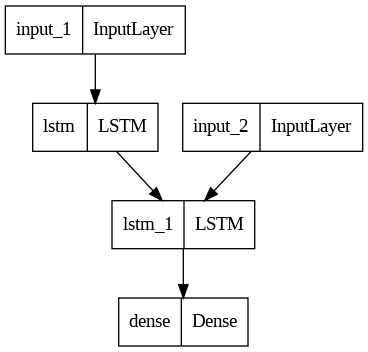

In [27]:
# Try plotting
keras.utils.plot_model(model)

Make sure to examine the rightmost column of the model summary  as well as the plot of the model. These diagnostics show the results of using the functional interface to Keras where we can connect a layer to another layer in a way that goes beyond the simple sequential addition of layers. In the plot, the second LSTM receives input from both the thought vector (the final h and C state of the first LSTM) as well as the decoder input data with its start and end tokens.

## Train the model


In [28]:
# With GPU on and 28,000 instances, each epoch after the first one should take
# about five seconds, for a total training time of under two minutes.
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)



Epoch 1/15
350/350 [==============================] - 14s 15ms/step - loss: 1.1706 - categorical_accuracy: 0.7056 - val_loss: 0.9538 - val_categorical_accuracy: 0.7336
Epoch 2/15
350/350 [==============================] - 4s 12ms/step - loss: 0.8300 - categorical_accuracy: 0.7629 - val_loss: 0.7518 - val_categorical_accuracy: 0.7822
Epoch 3/15
350/350 [==============================] - 4s 11ms/step - loss: 0.7094 - categorical_accuracy: 0.7927 - val_loss: 0.6768 - val_categorical_accuracy: 0.8014
Epoch 4/15
350/350 [==============================] - 4s 11ms/step - loss: 0.6507 - categorical_accuracy: 0.8084 - val_loss: 0.6277 - val_categorical_accuracy: 0.8147
Epoch 5/15
350/350 [==============================] - 4s 12ms/step - loss: 0.6078 - categorical_accuracy: 0.8208 - val_loss: 0.5872 - val_categorical_accuracy: 0.8270
Epoch 6/15
350/350 [==============================] - 4s 11ms/step - loss: 0.5745 - categorical_accuracy: 0.8300 - val_loss: 0.5635 - val_categorical_accuracy: 0.83

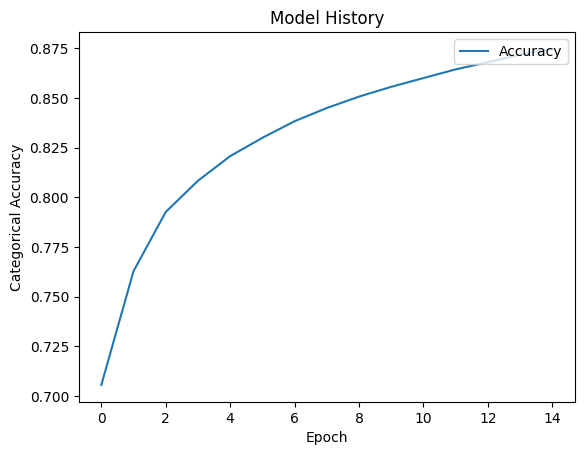

In [29]:
# Graphing code fragment modified from Rahul Verma on Stackoverflow
from matplotlib import pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.title('Model History')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='upper right')
plt.show()

#Checkpoint! - Write your final accuracy on the white board

Locate the value of categorical accuracy from the final epoch reported just above. Write your name on the board with the accuracy value.

In [30]:
#
# Exercise 11.6: Based on the training curve above, does the model need
# more training epochs? If so, run additional training epochs.
#
#Yes the model can get more accuracy with more epochs.

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

#The accuracy is increasing by 4% with more training, but it could also overfit.

Epoch 1/15
350/350 [==============================] - 5s 15ms/step - loss: 0.4094 - categorical_accuracy: 0.8777 - val_loss: 0.4191 - val_categorical_accuracy: 0.8747
Epoch 2/15
350/350 [==============================] - 4s 11ms/step - loss: 0.4004 - categorical_accuracy: 0.8802 - val_loss: 0.4095 - val_categorical_accuracy: 0.8780
Epoch 3/15
350/350 [==============================] - 4s 11ms/step - loss: 0.3922 - categorical_accuracy: 0.8826 - val_loss: 0.4057 - val_categorical_accuracy: 0.8784
Epoch 4/15
350/350 [==============================] - 4s 12ms/step - loss: 0.3843 - categorical_accuracy: 0.8847 - val_loss: 0.3991 - val_categorical_accuracy: 0.8811
Epoch 5/15
350/350 [==============================] - 4s 11ms/step - loss: 0.3771 - categorical_accuracy: 0.8872 - val_loss: 0.3937 - val_categorical_accuracy: 0.8829
Epoch 6/15
350/350 [==============================] - 4s 11ms/step - loss: 0.3701 - categorical_accuracy: 0.8890 - val_loss: 0.3885 - val_categorical_accuracy: 0.884

In [ ]:
# Optionally save the model to the VM disk

save_and_restore = False # Change this to true if you want to save your model

if save_and_restore:
  model.save("s2s")

In [ ]:
# Optionally zip the s2s directory so that it can be downloaded to your local
# machine. This would make it possible to restore the model.
# !zip -r s2s.zip s2s # Uncomment this to save zip file
# This zips down to about a few MB, depending upon the size of the LSTM layers.

# If you later upload the zip file to the file area for this VM, you can unzip 
# the s2s.zip file into the corresponding directory of model data:
# !unzip s2s.zip

## Run inference (sampling)

1. Encode input and retrieve initial decoder state
2. Run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [ ]:
# Optionally restore the model from disk.
if save_and_restore:
  model = keras.models.load_model("s2s")


We're now going to construct the inference modules. Note that this construction process grabs weights from the trained model. That means that anytime you do more training or make other changes that would impact the weights in the trained model, you must rerun this next block to get the weights into the inference modules.

In [ ]:
# Construct the encoder and decoder inference modules: Unlike the training
# model, these are completely separate from one another. The encoder will be
# used to create an initial thought vector and then the decoder will do all
# the work of generating translated phrases.

encoder_inputs = model.input[0]  # Encoder input layer: Get weights from the trained model
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # First LSTM

# This is the "thought vector" the hidden state that is used to start the decoder
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # This is the second/decoder input layer: Get weights from the trained model
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[3] # Second LSTM: Get weights from the trained model 

decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[4] # Dense output layer: Get weights from the trained model

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)


In [ ]:
encoder_model.summary() # Very simple!

In [ ]:
decoder_model.summary() # Looks like three sources of input, but really only two.
# The first is the decoder input data: start and end tokens and French phrase characters.
# The latter two are the h and C components of the thought vector.

In [ ]:
#
# Exercise 11.7: Examine the type and shape of the model objects created in
# the previous block. Explain what you see in a comment.
#

In [ ]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


In [ ]:
#
# Exercise 11.8: Examine the two reverse target indices created in the 
# previous block to confirm the nature of the keys and values. Write a 
# comment explaining what you see. 
#


In [ ]:
# Create a function to decode the sequences. This takes a one-hot encoded 
# input sequence as the input. It runs the encoder model with that input to
# generate the "thought vector." The thought vector is fed to the decoder
# model and a \t is issued to the decoder to start producing a sequence.

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    #start = time.process_time()
    states_value = encoder_model.predict(input_seq)
    #print("Encoding:", time.process_time() - start)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ""
    
    # Always a little risky to use a while loop, but we don't know what 
    # length of sentence the decoder will issue - that's pretty much the 
    # whole point of a sequence-to-sequence model, right?
    while not stop_condition:
        #start = time.process_time()
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=False)
        #print("Decoding:", time.process_time() - start)
        
        # Sample a token: Find the index of the most probable output character
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Use our reversing dictionary to decode the predicted character
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length of a decoder output sequence
        # or find that the decoder has issued a stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))

        # This one-hot encodes the current character to use as input for the next iteration
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    
    return decoded_sentence


#Discuss With Your Partner

Examine the loop in the function described above. Why is the encoder only run one time? What does that one call to the encoder produce?

How does the loop known when to stop? As the loop is concluding its first iteration and preparing to start its next iteration, what information is saved or created to guide the next iteration?

In other words, at time t+1 in the decoder loop, what does the decoder model need to know about what happened at time t?

For this first test, we will simply grab a few of the training sequences and push them through the model to see what gets predicted. Presumably an ideal model would largely reproduce the input->target pairs that appeared in the training, but there are two things to keep in mind. First, we have multiple instances where the same English sentence translates to different French sentences. That means the model can never really learn one correct answer for mapping an input sequence to a target sequence. Second, the thought vector, by nature of the fact that it is a low dimensional "bottleneck" in the model, represents a set of compromises on what should be produced. Various inputs could produce thought vectors with high cosine similarity and these will generally produce similar target sequences. Third, the model may not be sufficiently trained yet to produce good outputs.

In [ ]:
# The range() call controls how many input sequences we will test.
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]

    # Here's where we call our custom function
    decoded_sentence = decode_sequence(input_seq)

    print("Input sentence:", input_texts[seq_index], "Decoded sentence:", decoded_sentence)
    

In [ ]:
#
# Exercise 11.9: Try some different ranges of input sentences, such as 
# range(50,56) to examine translations from various sections of the training
# data. Do two or three examples to get a feel for different kinds of input
# and output sentences.
#

In [ ]:
# Next we will write an encoder so we can take an arbitrary
# English phrase, one-hot encode it, and then translate it to French.

my_phrase = "Find help."

if len(my_phrase) <= max_encoder_seq_length:
    # Fill up a single one-hot encodign vector with zeroes
    my_input_data =  np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")

    # Iterate over all of the characters in the input phrase
    for t, char in enumerate(my_phrase):
        my_input_data[0, t, input_token_index[char]] = 1.0

    # This adds padding with spaces
    my_input_data[0, t + 1 :, input_token_index[" "]] = 1.0

else:
    print("Input phrase is longer than the maximum encoder sequence length.")

In [ ]:
# This should show that the object we created above is one-hot encoded.
my_input_data.shape 

In [ ]:
#
# Exercise 11.10: Use the code above to write a user-defined function that you
# can call with a string variable as its input. The function should
# return a one-hot encoded vector that can be used to call decode_sequence(). 
# Here's an example of the first line: def en2french(my_phrase):
#

In [ ]:
# This call to decode_sequence() uses the one-hot coded input data we 
# created above for our new sample phrase. 
decoded_sentence = decode_sequence(my_input_data)
print("Input sentence:", my_phrase)
print("Decoded sentence:", decoded_sentence)

In [ ]:
#
# Exercise 11.11: Update your new custom function so that it includes the call
# to decode_sequence() and returns the output string. 
#

In [ ]:
#
# Exercise 11.12: What can you do to improve the validation accuaracy of the
# seq2seq model you trained? You could add more LSTM layers. You could change 
# the batch size. You could change the proportion of validation samples. You
# could change the learning rate or implement a dynamic learning rate. Based 
# on what you have learned in class, try at least two of these changes 
# (one at a time) to see if you can improve model validation quality.
#
#

In [ ]:
#
# Exercise 11.13: Go to http://www.manythings.org/anki/ and examine some of the
# other language pairs that are available. Add a comment describing one
# of the files you see.
#

In [ ]:
#
# Exercise 11.14: Use Google translate in a loop to produce translations of the 
# model output that you can compare to the input you used.
#
# !pip install googletrans==3.1.0a0 # Uncomment this to get Google translate
# 
# from googletrans import Translator, constants # Uncomment this to get Google translate
#
# translator = Translator() # Uncomment this to instantiate the Google API translator
#
# translation = translator.translate(my_text, dest="en") # Uncomment this to do a translation
# translation.text # Uncomment this to view the results

In [ ]:
#
# Exercise 11.15: Put five short English test sentences into a list. Write a loop
# that translates each sentence into French and then uses Google translate to 
# show the English "back translation" of the French model output.
#